In [31]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt

def read_healpix_map(CMB_map_path):
    original_healpix_map = hp.read_map(CMB_map_path)
    hp.mollview(
        original_healpix_map * 1e6,
        coord=["G"],
        title="Full Sky CMB",
        unit=r"$μ$K",
        min=-300,
        max=300,
    )
    plt.show()
    return original_healpix_map

def hp_map_2_hp_alm(healpix_map, L_max):
    hp_alm = hp.map2alm(healpix_map, lmax=L_max - 1)
    return hp_alm

def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm

def wavelet_transform(mw_map, L_max, N_directions):
    filter = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs = s2wav.analysis(mw_map, N=N_directions, L=L_max, filters=filter, reality=False)
    return MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs

def save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization):
    for i, wav in enumerate(wavelet_coeffs):
        np_wav = np.array(wav)  # Convert JAX array to numpy array
        np.save(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{i}_testing_{realization:04d}", np_wav)

    np_scal = np.array(scaling_coeffs)
    np.save(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}_testing_{realization:04d}", np_scal)

def load_wavelet_scaling_coeffs(frequency, num_wavelets, realization):
    wavelet_coeffs = [np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{i}_testing_{realization:04d}.npy")) for i in range(num_wavelets)]
    scaling_coeffs = np.real(np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}_testing_{realization:04d}.npy"))
    return wavelet_coeffs, scaling_coeffs

def generate_wavelets(CMB_map_path, frequency, L_max, N_directions, realization):
    # Step 1: Read the Healpix map
    healpix_map = read_healpix_map(CMB_map_path)

    # Step 2: Convert Healpix map to spherical harmonic coefficients
    hp_alm = hp_map_2_hp_alm(healpix_map, L_max)

    # Step 3: Convert spherical harmonics to MW coefficients
    mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)

    # Step 4: Transform MW coefficients back to a map (optional, based on use case)
    original_MW_Map = s2fft.inverse(mw_alm, L_max)
    np.save(f'wavelet_transform/maps/Original_MW_Pix_map_{frequency}_{realization:04d}.npy', original_MW_Map)

    # Step 5: Apply wavelet transform to the MW map to get wavelet and scaling coefficients
    wavelet_coeffs, scaling_coeffs = wavelet_transform(original_MW_Map, L_max, N_directions)

    # Step 6: Save the wavelet and scaling coefficients
    save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization)

    # Step 7: Load the wavelet and scaling coefficients
    loaded_wavelet_coeffs, loaded_scaling_coeffs = load_wavelet_scaling_coeffs(frequency, len(wavelet_coeffs), realization)

    # Print shapes for verification
    for i in range(len(loaded_wavelet_coeffs)):
        print(loaded_wavelet_coeffs[i].shape)
    return loaded_wavelet_coeffs, loaded_scaling_coeffs

# if __name__ == "__main__":
#     frequency = "030"
#     L_max = 16
#     N_directions = 1
#     realization = 0  # Example realization number
#     CMB_map_path = f'../data/planck_simulation/ffp10_newdust_total_{frequency}_full_map.fits'

#     generate(CMB_map_path, frequency, L_max, N_directions, realization)


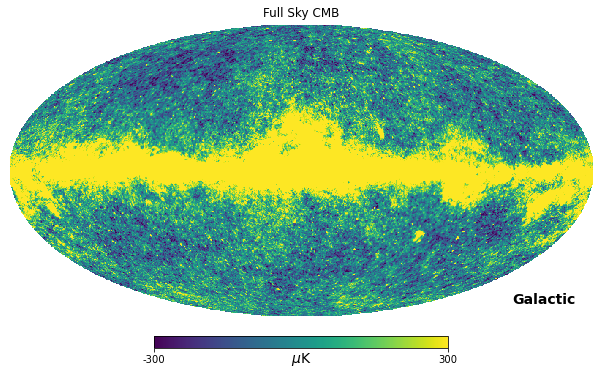

(1, 4, 7)
(1, 4, 7)
(1, 8, 15)
(1, 16, 31)
(1, 16, 31)


In [32]:
frequency = "030"
# Step 1: Read the Healpix map
CMB_map_path = f'../data/planck_simulation/ffp10_newdust_total_{frequency}_full_map.fits'
L_max = 16
N_directions = 1
realization = 0

wavelet, scal = generate_wavelets(CMB_map_path, frequency, L_max, N_directions, realization)
